In [5]:
# Install all required packages with compatible versions
!pip install numpy==1.24.3 pandas==2.1.1 scikit-learn==1.3.2 scipy==1.11.3 matplotlib==3.8.0 seaborn==0.13.0 sentence-transformers==2.2.2 tensorflow==2.15.0 transformers==4.35.0 datasets==2.14.0 nltk==3.8.1 tqdm==4.66.1 --force-reinstall --no-cache-dir

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of contourpy to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.2 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 39.5 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 42.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 14.1 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 43.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 42.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 45.2 MB/s  0:00:00


In [6]:
# Libraries

import os
import gzip
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# NLP libraries
from sentence_transformers import SentenceTransformer

# Set random seeds for reproducibility
np.random.seed(42)


In [7]:
# Create directory structure
directories = [
    'data/raw',
    'data/processed', 
    'data/embeddings',
    'results/figures',
    'results/metrics',
    'models'
]

for directory in directories:
    Path(directory).mkdir(parents=True, exist_ok=True)

In [ ]:

file_path = 'data/raw/Video_Games.jsonl.gz'

print(f"Loading dataset from: {file_path}")

Loading dataset from: data/raw/Video_Games.jsonl.gz


In [12]:
# Load and sample 150K reviews from the file
sample_size = 150000
samples = []

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= sample_size:
            break
        
        try:
            review = json.loads(line.strip())
            samples.append(review)
        except json.JSONDecodeError:
            continue
        
        if (i + 1) % 10000 == 0:
            print(f"  Loaded {i + 1:,} reviews...")

df = pd.DataFrame(samples)

print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

  Loaded 10,000 reviews...
  Loaded 20,000 reviews...
  Loaded 30,000 reviews...
  Loaded 40,000 reviews...
  Loaded 50,000 reviews...
  Loaded 60,000 reviews...
  Loaded 70,000 reviews...
  Loaded 80,000 reviews...
  Loaded 90,000 reviews...
  Loaded 100,000 reviews...
  Loaded 110,000 reviews...
  Loaded 120,000 reviews...
  Loaded 130,000 reviews...
  Loaded 140,000 reviews...
  Loaded 150,000 reviews...

Dataset shape: (150000, 10)

Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


In [13]:
# first few rows
df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,4.0,It’s pretty sexual. Not my fav,I’m playing on ps5 and it’s interesting. It’s...,[],B07DJWBYKP,B07DK1H3H5,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1608186804795,0,True
1,5.0,Good. A bit slow,Nostalgic fun. A bit slow. I hope they don’t...,[],B00ZS80PC2,B07SRWRH5D,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,1587051114941,1,False
2,5.0,... an order for my kids & they have really en...,This was an order for my kids & they have real...,[],B01FEHJYUU,B07MFMFW34,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,1490877431000,0,True
3,5.0,Great alt to pro controller,"These work great, They use batteries which is ...",[],B07GXJHRVK,B0BCHWZX95,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,1577637634017,0,True
4,5.0,solid product,I would recommend to anyone looking to add jus...,[],B00HUWA45W,B00HUWA45W,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,1427591932000,0,True


In [15]:
### Intial Data Exploration ###
print(f"Total reviews: {len(df):,}")
print(f"\nColumns: {len(df.columns)}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nData types:")
print(df.dtypes)
print("Missing values:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nRating distribution:")
print(df['rating'].value_counts().sort_index())

Total reviews: 150,000

Columns: 10

Memory usage: 118.70 MB

Data types:
rating               float64
title                 object
text                  object
images                object
asin                  object
parent_asin           object
user_id               object
timestamp              int64
helpful_vote           int64
verified_purchase       bool
dtype: object
Missing values:
Series([], dtype: int64)

Rating distribution:
rating
1.0    13674
2.0     7473
3.0    12189
4.0    21827
5.0    94837
Name: count, dtype: int64


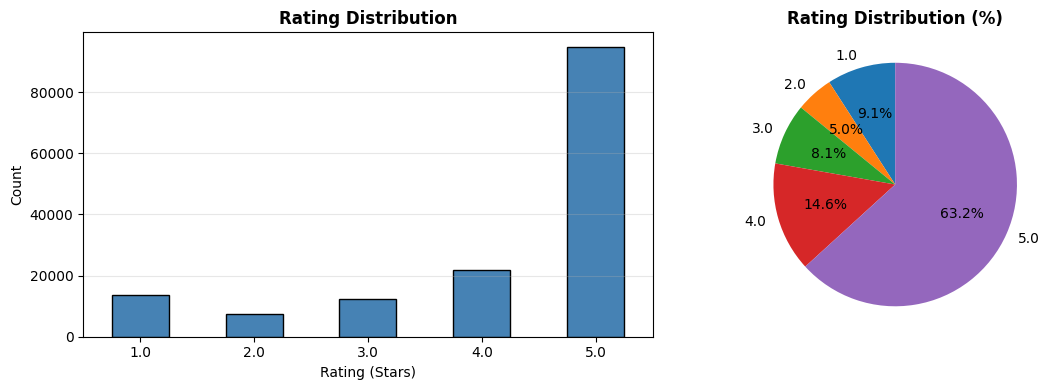

In [16]:
# Rating distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
rating_counts = df['rating'].value_counts().sort_index()

rating_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Rating Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Rating (Stars)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(axis='y', alpha=0.3)

rating_counts.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Rating Distribution (%)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('results/figures/rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
### Preprocessing ###
df_clean = df.dropna(subset=['text', 'rating']).copy()
df_clean = df_clean[df_clean['text'].str.len() >= 10].copy()

# Map to sentiment: 0=Negative (1-2 stars), 1=Neutral (3 stars), 2=Positive (4-5 stars)
df_clean['sentiment'] = df_clean['rating'].apply(
    lambda x: 0 if x <= 2.0 else (1 if x == 3.0 else 2)
)

print(f"Cleaned: {len(df_clean):,} reviews")
print("\nSentiment distribution:")
for sent, label in enumerate(['Negative', 'Neutral', 'Positive']):
    count = (df_clean['sentiment'] == sent).sum()
    print(f"  {label}: {count:,} ({count/len(df_clean)*100:.1f}%)")

Cleaned: 143,156 reviews

Sentiment distribution:
  Negative: 20,946 (14.6%)
  Neutral: 11,869 (8.3%)
  Positive: 110,341 (77.1%)


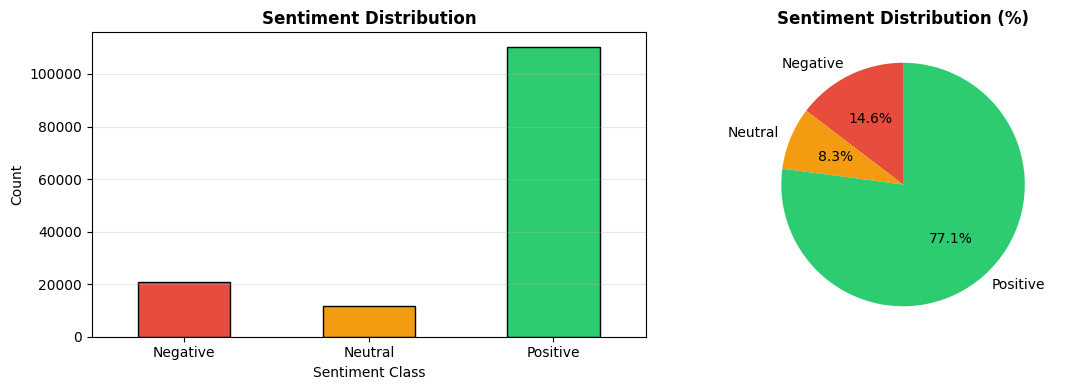

In [18]:
# Sentiment distribution plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sentiment_counts = df_clean['sentiment'].value_counts().sort_index()
labels = ['Negative', 'Neutral', 'Positive']
colors = ['#e74c3c', '#f39c12', '#2ecc71']

sentiment_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Sentiment Distribution', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sentiment Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(labels, rotation=0)
axes[0].grid(axis='y', alpha=0.3)

axes[1].pie(sentiment_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Sentiment Distribution (%)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('results/figures/sentiment_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# Text statistics
df_clean['text_length'] = df_clean['text'].str.len()
df_clean['word_count'] = df_clean['text'].str.split().str.len()

print("Text statistics:")
print(f"  Char length - Mean: {df_clean['text_length'].mean():.0f}, Median: {df_clean['text_length'].median():.0f}")
print(f"  Word count - Mean: {df_clean['word_count'].mean():.0f}, Median: {df_clean['word_count'].median():.0f}")

Text statistics:
  Char length - Mean: 364, Median: 150
  Word count - Mean: 67, Median: 28


In [20]:
# Stratified sampling to 100K
target_total = 100000
sentiment_dist = df_clean['sentiment'].value_counts(normalize=True)
samples_per_class = {sent: int(target_total * pct) for sent, pct in sentiment_dist.items()}

df_sampled = df_clean.groupby('sentiment', group_keys=False).apply(
    lambda x: x.sample(n=min(len(x), samples_per_class[x.name]), random_state=42)
).reset_index(drop=True)

print(f"Sampled to {len(df_sampled):,} reviews")
for sent, label in enumerate(['Negative', 'Neutral', 'Positive']):
    count = (df_sampled['sentiment'] == sent).sum()
    print(f"  {label}: {count:,} ({count/len(df_sampled)*100:.1f}%)")

Sampled to 99,998 reviews
  Negative: 14,631 (14.6%)
  Neutral: 8,290 (8.3%)
  Positive: 77,077 (77.1%)


## Train/Val/Test Split (80/10/10)

In [21]:
train_df, temp_df = train_test_split(df_sampled, test_size=0.2, stratify=df_sampled['sentiment'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['sentiment'], random_state=42)

print(f"Total: {len(df_sampled):,}")
print(f"Train: {len(train_df):,} ({len(train_df)/len(df_sampled)*100:.1f}%)")
print(f"Val:   {len(val_df):,} ({len(val_df)/len(df_sampled)*100:.1f}%)")
print(f"Test:  {len(test_df):,} ({len(test_df)/len(df_sampled)*100:.1f}%)")

Total: 99,998
Train: 79,998 (80.0%)
Val:   10,000 (10.0%)
Test:  10,000 (10.0%)


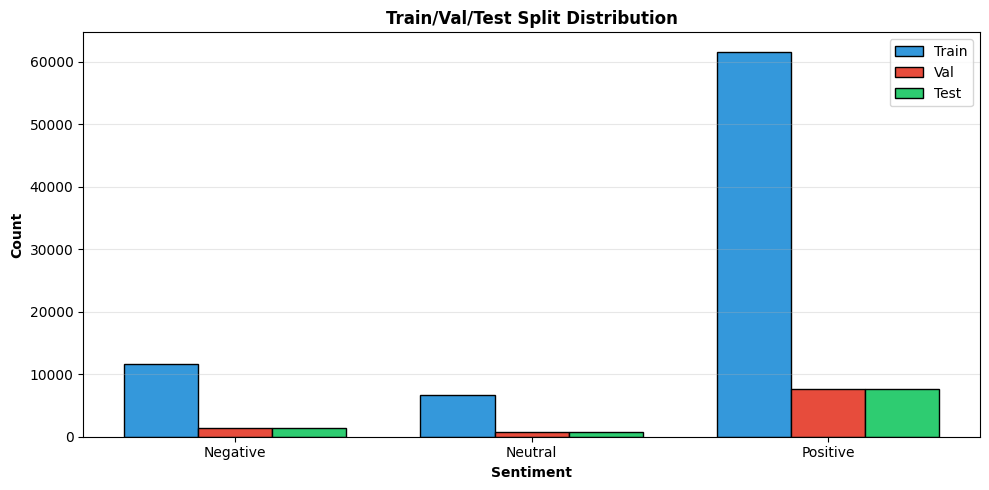

In [22]:
# Split distribution visualization
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(3)
width = 0.25
labels = ['Negative', 'Neutral', 'Positive']

train_counts = [sum(train_df['sentiment'] == i) for i in range(3)]
val_counts = [sum(val_df['sentiment'] == i) for i in range(3)]
test_counts = [sum(test_df['sentiment'] == i) for i in range(3)]

ax.bar(x - width, train_counts, width, label='Train', color='#3498db', edgecolor='black')
ax.bar(x, val_counts, width, label='Val', color='#e74c3c', edgecolor='black')
ax.bar(x + width, test_counts, width, label='Test', color='#2ecc71', edgecolor='black')

ax.set_xlabel('Sentiment', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')
ax.set_title('Train/Val/Test Split Distribution', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('results/figures/split_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

## Generate Embeddings (384-dimensions)

In [23]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Model loaded - Embedding dim: {embedding_model.get_sentence_embedding_dimension()}")

Model loaded - Embedding dim: 384


In [24]:
print(f"Generating train embeddings ({len(train_df):,} reviews)...")
train_embeddings = embedding_model.encode(train_df['text'].tolist(), batch_size=32, 
                                          show_progress_bar=True, convert_to_numpy=True)
print(f"Train: {train_embeddings.shape}")

Generating train embeddings (79,998 reviews)...


Batches:   0%|          | 0/2500 [00:00<?, ?it/s]

Train: (79998, 384)


In [25]:
val_embeddings = embedding_model.encode(val_df['text'].tolist(), batch_size=32, 
                                        show_progress_bar=True, convert_to_numpy=True)
print(f"Val: {val_embeddings.shape}")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Val: (10000, 384)


In [26]:
test_embeddings = embedding_model.encode(test_df['text'].tolist(), batch_size=32, 
                                         show_progress_bar=True, convert_to_numpy=True)
print(f"Test: {test_embeddings.shape}")

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Test: (10000, 384)


## Compute Class Weights

In [27]:
y_train = train_df['sentiment'].values
y_val = val_df['sentiment'].values
y_test = test_df['sentiment'].values

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for i, label in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"  {label}: {class_weights[i]:.4f}")

Class weights:
  Negative: 2.2782
  Neutral: 4.0208
  Positive: 0.4325


In [32]:
# Save 
np.save('data/embeddings/train_embeddings.npy', train_embeddings)
np.save('data/embeddings/val_embeddings.npy', val_embeddings)
np.save('data/embeddings/test_embeddings.npy', test_embeddings)

np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_val.npy', y_val)
np.save('data/processed/y_test.npy', y_test)

with open('data/processed/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weight_dict, f)

print("   - Embeddings: data/embeddings/*.npy")
print("   - Labels: data/processed/y_*.npy")
print("   - Class weights: data/processed/class_weights.pkl")

   - Embeddings: data/embeddings/*.npy
   - Labels: data/processed/y_*.npy
   - Class weights: data/processed/class_weights.pkl


In [29]:
# Save DataFrames
!pip install pandas==2.1.1 --upgrade
train_df.to_csv('data/processed/train.csv', index=False)
val_df.to_csv('data/processed/val.csv', index=False)
test_df.to_csv('data/processed/test.csv', index=False)

# Save embeddings
np.save('data/embeddings/train_embeddings.npy', train_embeddings)
np.save('data/embeddings/val_embeddings.npy', val_embeddings)
np.save('data/embeddings/test_embeddings.npy', test_embeddings)

# Save labels
np.save('data/processed/y_train.npy', y_train)
np.save('data/processed/y_val.npy', y_val)
np.save('data/processed/y_test.npy', y_test)

# Save class weights
with open('data/processed/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weight_dict, f)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


AttributeError: 'Index' object has no attribute '_format_native_types'